# Assignment 1 #
Karthik Karavatt
2061996
5

In [64]:
# imports 
import numpy as np
import cv2 as cv
import shutil
import os
from scipy.spatial import distance
from sklearn.cluster import KMeans
from scipy import ndimage
from sklearn.preprocessing import StandardScaler
from fastai.vision.all import *



In [65]:

# Read the image
img = cv.imread("digits.png")
# Convert the image to grayscale
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

## Task 2.1 Data Preparation 

### 2.1.1
Split the image into 5000 images of size 20x20 pixels each. Each image contains a digit.
Store this data in a numpy array

We know the digit is 20x20 pixels. So we can split the image into 5000 images of size 20x20 pixels each.
As the image is 1000x500 pixels, we can split the image into 50 rows and 100 columns.

In [66]:

# Split the image into 5000 cells of size 20x20 pixels each
data_cells = np.array([np.hsplit(row, 100) for row in np.vsplit(img, 50)])

data = np.array(data_cells)

### 2.1.2
Split the data into training and test sets. Use the first 1000 images for training and the rest for testing.
Every 5th row is a different digit, there are 5 rows of each digit and the digits go up to 9, we can use one row of each digit for training and the rest for testing. So we take one row from every 5 rows for training and the rest for testing
.

In [67]:
# Select every 5th row for testing
test_data = data[::5]

# Select all but every 5th row for training
# deletes every 5th row from data array
train_data = np.delete(data, np.arange(0, data.shape[0], 5), axis=0)

### 2.1.3
Write the images to a folders. The images should be written to the train and test directories.

In [68]:

# Define your directory paths
train_dir = 'train'
test_dir = 'test'

# If the directories already exist, remove them and their contents
for dir_path in [train_dir, test_dir]:
    if os.path.exists(dir_path) and os.path.isdir(dir_path):
        shutil.rmtree(dir_path)

    # Create the directories
    os.makedirs(dir_path)

# file names are the image labels as well 
for i in range(train_data.shape[0]):
    for j in range(train_data.shape[1]):
        digit = i // 4  # The digit is determined by integer division of the row index by 4
        row = i % 4  # The row is determined by the remainder of the row index divided by 4
        cv.imwrite(os.path.join(train_dir, f'train_{digit}_{row}_{j}.jpg'), train_data[i, j])

for i in range(test_data.shape[0]):
    for j in range(test_data.shape[1]):
        cv.imwrite(os.path.join(test_dir, f'test_{i}_{j}.jpg'), test_data[i, j])


def load_images_to_array(file_path):
    img_files = os.listdir(file_path)
    # Sort the files
    img_files.sort()
    # Load the images into a numpy array
    loaded_images = np.array([cv.imread(os.path.join(file_path, file), cv.IMREAD_GRAYSCALE) for file in img_files])
    return loaded_images

## Task 2.2: Nearest Neighbor method for image classification 

In this task we will use the k - nearest neighbor method to classify the images in the test set.
### 2.2
label the images in the training set. The labels should be the digit in the image.

In [69]:
# Load the images from the train and test directories into numpy arrays
train_data = load_images_to_array(train_dir)
test_data = load_images_to_array(test_dir)

# Reshape the training data to be 2D with 400 columns and convert to float32
train_data = train_data.reshape(-1, 400)
train_data = np.float32(train_data)

# Reshape the test data to be 2D and convert to float32
test_data = test_data.reshape(-1, 400)
test_data = np.float32(test_data)

# Create the labels for the training data
train_labels = np.repeat(np.arange(10), 400).reshape(-1, 1)
# Create the labels for the test data
test_labels = np.repeat(np.arange(10), 100).reshape(-1, 1)

# Validate labeling
#import matplotlib.pyplot as plt
#
#image_index = 0  # Index of the image you want to plot
#image = train_data[image_index]  # Get the image data
#
## Reshape the image data back to 2D (20x20 if the original image was that size)
#image_2d = image.reshape(20, 20)
#
## Now you can plot the image
#plt.figure()
#plt.imshow(image_2d, cmap='gray')  # Display the image in grayscale
#plt.title(f'Label: {train_labels[image_index]}')  # Display the label as the title
#plt.show()

### 2.3 Implement the k - nearest neighbor method to classify the images in the test set.

In [70]:
def get_accuracy_and_confusion_matrix(k):
    # Create the kNN model
    knn_model = cv.ml.KNearest_create()
    knn_model.train(train_data, cv.ml.ROW_SAMPLE, train_labels)
    ret, knn_result, neighbours, dist = knn_model.findNearest(test_data, k=k)
    # Calculate the accuracy of classification
    knn_matches = np.equal(knn_result, test_labels)
    knn_correct = np.count_nonzero(knn_matches)
    knn_accuracy = knn_correct * (100.0 / knn_result.size)
    print(f'Accuracy is {knn_accuracy}%')

    # Convert the test labels and the predicted results to integer type
    test_labels_int = test_labels.astype(int)
    result_int = knn_result.astype(int)

    # Get the number of classes
    num_classes = len(np.unique(test_labels_int))

    # Initialize the confusion matrix
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)

    # Populate the confusion matrix
    for j in range(len(test_labels_int)):
        confusion_matrix[test_labels_int[j][0]][result_int[j][0]] += 1

    # Print the confusion matrix in latex format for markdown
    print(f'k = {k}')
    print(r'$\begin{bmatrix}')
    for row in confusion_matrix:
        for knn_i, col in enumerate(row):
            if knn_i == len(row) - 1:
                print(f'{col}\\\\')
            else:
                print(f'{col}&', end='')
    print(r'\end{bmatrix}$')
    print('\n')


get_accuracy_and_confusion_matrix(3)


Accuracy is 93.10000000000001%
k = 3
$\begin{bmatrix}
100&0&0&0&0&0&0&0&0&0\\
0&98&1&1&0&0&0&0&0&0\\
2&5&88&0&0&1&0&4&0&0\\
1&0&2&91&0&3&1&2&0&0\\
0&1&0&0&90&1&1&0&0&7\\
0&2&1&6&0&88&1&0&0&2\\
1&0&0&0&0&0&99&0&0&0\\
0&3&0&0&1&0&0&92&0&4\\
0&4&1&1&0&0&0&0&93&1\\
4&0&0&1&2&0&0&1&0&92\\
\end{bmatrix}$


| k  | Accuracy           |
|----|--------------------|
| 1  | 92.60000000000001% |
| 2  | 92.2%              |
| 3  | 93.10000000000001% |
| 4  | 92.7%              |
| 5  | 92.10000000000001% |
| 6  | 92.0%              |
| 7  | 92.0%              |
| 8  | 91.9%              |
| 9  | 91.80000000000001% |
| 10 | 92.0%              |
| 11 | 90.9%              |
| 12 | 90.9%              |
| 13 | 90.80000000000001% |
| 14 | 90.80000000000001% |
| 15 | 90.60000000000001% |
| 16 | 90.10000000000001% |
| 17 | 90.2%              |
| 18 | 90.30000000000001% |
| 19 | 90.10000000000001% |
| 20 | 89.9%              |


k = 1
$\begin{bmatrix}
98&0&2&0&0&0&0&0&0&0\\
0&97&2&1&0&0&0&0&0&0\\
1&3&86&3&1&1&0&4&0&1\\
0&0&0&93&0&2&1&2&2&0\\
0&0&0&0&90&1&0&1&0&8\\
0&1&1&4&0&89&1&0&0&4\\
1&0&0&0&1&1&97&0&0&0\\
0&3&0&0&1&0&0&91&0&5\\
0&2&0&2&0&1&0&0&95&0\\
3&0&0&0&2&0&1&4&0&90\\
\end{bmatrix}$


k = 2
$\begin{bmatrix}
100&0&0&0&0&0&0&0&0&0\\
0&98&2&0&0&0&0&0&0&0\\
3&5&87&0&0&1&0&4&0&0\\
1&0&3&91&0&1&1&2&1&0\\
0&1&0&0&95&0&0&2&0&2\\
0&1&1&9&2&86&0&0&0&1\\
1&1&0&0&1&2&95&0&0&0\\
0&4&0&0&2&0&0&93&0&1\\
0&5&1&1&0&3&0&0&90&0\\
4&0&0&1&4&0&0&4&0&87\\
\end{bmatrix}$


k = 3
$\begin{bmatrix}
100&0&0&0&0&0&0&0&0&0\\
0&98&1&1&0&0&0&0&0&0\\
2&5&88&0&0&1&0&4&0&0\\
1&0&2&91&0&3&1&2&0&0\\
0&1&0&0&90&1&1&0&0&7\\
0&2&1&6&0&88&1&0&0&2\\
1&0&0&0&0&0&99&0&0&0\\
0&3&0&0&1&0&0&92&0&4\\
0&4&1&1&0&0&0&0&93&1\\
4&0&0&1&2&0&0&1&0&92\\
\end{bmatrix}$


k = 4
$\begin{bmatrix}
100&0&0&0&0&0&0&0&0&0\\
0&97&1&1&1&0&0&0&0&0\\
2&7&86&0&0&1&0&4&0&0\\
1&0&2&92&0&1&1&2&1&0\\
0&1&0&0&93&0&1&0&0&5\\
0&2&1&4&0&90&1&0&0&2\\
1&1&0&0&0&0&98&0&0&0\\
0&5&0&0&1&0&0&91&0&3\\
0&3&0&2&0&0&0&0&94&1\\
1&0&1&2&5&0&2&3&0&86\\
\end{bmatrix}$


k = 5
$\begin{bmatrix}
99&0&0&0&0&0&1&0&0&0\\
0&98&0&1&0&1&0&0&0&0\\
2&6&86&0&0&1&0&5&0&0\\
1&0&2&91&0&2&1&2&1&0\\
0&2&0&0&90&1&2&0&0&5\\
0&1&1&5&0&88&2&0&0&3\\
1&1&0&0&0&0&98&0&0&0\\
0&4&0&0&1&0&0&92&0&3\\
0&3&1&3&0&1&1&0&90&1\\
1&0&1&1&2&0&2&4&0&89\\
\end{bmatrix}$


k = 6
$\begin{bmatrix}
99&0&0&0&0&0&1&0&0&0\\
0&98&0&1&0&1&0&0&0&0\\
3&7&86&0&0&0&0&4&0&0\\
0&0&2&92&0&1&1&2&1&1\\
0&2&0&0&92&0&2&0&0&4\\
0&1&1&6&1&88&1&0&0&2\\
1&1&0&0&0&0&98&0&0&0\\
0&5&0&0&1&0&0&90&0&4\\
0&4&1&2&0&2&1&0&89&1\\
3&0&0&2&2&1&0&4&0&88\\
\end{bmatrix}$


k = 7
$\begin{bmatrix}
98&0&0&0&0&2&0&0&0&0\\
0&98&1&1&0&0&0&0&0&0\\
2&7&84&0&0&1&0&6&0&0\\
0&0&2&92&0&1&1&2&1&1\\
0&2&0&0&92&0&2&0&0&4\\
0&1&1&5&0&88&2&0&0&3\\
1&1&0&0&0&0&98&0&0&0\\
0&5&0&0&0&0&0&92&0&3\\
0&4&0&4&0&1&1&0&89&1\\
2&0&0&1&2&1&0&5&0&89\\
\end{bmatrix}$


k = 8
$\begin{bmatrix}
99&0&0&0&0&0&1&0&0&0\\
0&97&2&0&1&0&0&0&0&0\\
2&8&85&0&0&1&0&4&0&0\\
0&0&2&92&0&1&1&2&1&1\\
0&3&0&0&90&0&2&0&0&5\\
0&1&1&7&0&87&1&0&0&3\\
1&1&0&0&0&0&98&0&0&0\\
0&5&0&0&0&0&0&92&0&3\\
0&4&0&2&0&1&1&0&91&1\\
3&0&0&1&2&0&1&5&0&88\\
\end{bmatrix}$


k = 9
$\begin{bmatrix}
97&0&0&0&0&2&1&0&0&0\\
0&98&0&1&0&1&0&0&0&0\\
2&9&84&0&0&1&0&4&0&0\\
0&0&2&91&0&2&1&2&1&1\\
0&3&0&0&90&0&2&0&0&5\\
0&1&1&6&0&88&1&0&0&3\\
1&1&0&0&0&0&98&0&0&0\\
0&5&0&0&0&0&0&92&0&3\\
0&4&0&2&0&2&1&0&90&1\\
2&0&0&1&1&1&0&5&0&90\\
\end{bmatrix}$


k = 10
$\begin{bmatrix}
98&0&0&0&0&1&1&0&0&0\\
0&98&0&1&0&1&0&0&0&0\\
2&9&84&0&0&1&0&4&0&0\\
1&0&2&92&0&1&1&2&0&1\\
0&3&0&0&90&0&2&0&0&5\\
0&1&1&7&1&87&1&0&0&2\\
1&1&0&0&0&0&98&0&0&0\\
0&5&0&0&0&0&0&92&0&3\\
0&4&0&2&0&2&1&0&90&1\\
2&0&0&1&1&1&0&4&0&91\\
\end{bmatrix}$


k = 11
$\begin{bmatrix}
96&0&0&0&0&2&2&0&0&0\\
0&98&0&0&0&1&0&0&0&1\\
3&9&82&0&0&1&0&5&0&0\\
1&1&1&90&0&2&1&2&0&2\\
0&3&0&0&90&0&2&0&0&5\\
0&1&1&7&0&86&1&0&1&3\\
1&1&0&0&0&0&98&0&0&0\\
0&6&0&0&1&0&0&90&0&3\\
0&4&0&2&0&2&1&0&90&1\\
2&0&0&1&2&1&0&5&0&89\\
\end{bmatrix}$


k = 12
$\begin{bmatrix}
96&0&0&0&0&3&1&0&0&0\\
0&97&0&0&1&1&0&0&0&1\\
3&8&82&0&0&1&0&6&0&0\\
1&1&2&90&0&2&1&2&0&1\\
0&4&0&0&88&1&2&0&0&5\\
0&1&1&5&0&89&1&0&0&3\\
1&1&0&0&0&0&98&0&0&0\\
0&6&0&0&1&0&0&90&0&3\\
0&4&0&2&0&2&1&0&90&1\\
2&0&0&1&3&0&1&4&0&89\\
\end{bmatrix}$


k = 13
$\begin{bmatrix}
96&0&0&0&0&2&2&0&0&0\\
0&98&0&0&0&1&0&0&0&1\\
3&9&80&0&0&1&0&7&0&0\\
1&1&1&91&0&1&1&3&0&1\\
0&4&0&0&90&0&2&0&0&4\\
0&1&1&5&1&88&1&0&0&3\\
1&1&0&0&0&0&98&0&0&0\\
0&6&0&0&0&0&0&91&0&3\\
0&3&0&4&0&3&1&0&88&1\\
2&0&1&1&2&0&1&5&0&88\\
\end{bmatrix}$


k = 14
$\begin{bmatrix}
96&0&0&0&0&2&2&0&0&0\\
0&98&0&0&0&1&0&1&0&0\\
2&9&81&0&0&1&0&6&1&0\\
1&1&1&91&0&1&1&3&0&1\\
0&4&0&0&87&1&2&0&0&6\\
0&1&1&5&1&88&1&0&0&3\\
1&1&0&0&0&0&98&0&0&0\\
0&6&0&0&0&0&0&91&0&3\\
0&3&0&3&0&3&1&0&89&1\\
2&0&0&1&3&0&1&4&0&89\\
\end{bmatrix}$


k = 15
$\begin{bmatrix}
96&0&0&0&0&2&2&0&0&0\\
0&97&0&0&1&1&0&0&0&1\\
2&9&81&0&0&1&0&6&0&1\\
1&1&1&91&0&1&1&3&0&1\\
0&4&0&0&90&0&2&0&0&4\\
0&1&1&6&0&86&2&0&0&4\\
1&1&0&0&0&0&98&0&0&0\\
0&7&0&0&1&0&0&88&0&4\\
0&3&0&3&0&3&1&0&89&1\\
2&0&0&1&1&0&1&5&0&90\\
\end{bmatrix}$


k = 16
$\begin{bmatrix}
96&0&0&0&0&2&2&0&0&0\\
0&97&0&0&1&1&0&0&0&1\\
2&9&80&0&0&1&0&6&1&1\\
1&1&1&89&0&2&1&3&0&2\\
0&4&0&0&88&0&2&0&0&6\\
0&1&1&5&0&88&1&0&0&4\\
1&1&0&0&0&1&97&0&0&0\\
0&7&0&0&1&0&0&88&0&4\\
0&5&0&4&0&2&1&0&87&1\\
2&0&0&1&1&0&1&4&0&91\\
\end{bmatrix}$


k = 17
$\begin{bmatrix}
96&0&0&0&0&2&2&0&0&0\\
0&97&0&0&1&1&0&1&0&0\\
3&9&79&0&0&1&0&6&1&1\\
1&1&2&87&0&2&1&3&0&3\\
0&4&0&0&90&0&2&0&0&4\\
0&1&1&6&1&86&2&0&0&3\\
1&1&0&0&0&1&97&0&0&0\\
0&6&0&0&1&0&0&90&0&3\\
0&3&0&3&0&3&1&0&89&1\\
2&0&0&1&1&0&1&4&0&91\\
\end{bmatrix}$


k = 18
$\begin{bmatrix}
96&0&0&0&0&2&2&0&0&0\\
0&97&0&0&1&1&0&1&0&0\\
2&9&81&0&0&1&0&5&1&1\\
1&1&2&85&0&3&1&3&0&4\\
0&4&0&0&90&0&2&0&0&4\\
0&1&1&6&1&87&1&0&0&3\\
1&1&0&0&0&1&97&0&0&0\\
0&6&0&0&1&0&0&90&0&3\\
0&3&0&3&0&3&1&0&89&1\\
2&1&0&1&1&0&1&3&0&91\\
\end{bmatrix}$


k = 19
$\begin{bmatrix}
96&0&0&0&0&2&2&0&0&0\\
0&97&0&0&1&1&0&1&0&0\\
2&9&81&0&0&1&0&5&1&1\\
1&1&2&85&0&3&1&3&0&4\\
0&4&0&0&91&0&2&0&0&3\\
0&1&1&6&1&86&2&0&0&3\\
1&1&0&0&0&1&97&0&0&0\\
0&7&0&0&1&0&0&89&0&3\\
0&3&0&3&0&3&1&0&89&1\\
2&1&0&1&1&0&1&4&0&90\\
\end{bmatrix}$


k = 20
$\begin{bmatrix}
96&0&1&0&0&2&1&0&0&0\\
0&97&0&0&1&1&0&0&0&1\\
2&9&81&0&0&1&0&5&1&1\\
1&1&2&85&0&3&1&3&0&4\\
0&4&0&0&90&0&2&0&0&4\\
0&1&1&6&1&87&1&0&0&3\\
1&1&0&0&0&1&97&0&0&0\\
0&7&0&0&1&0&0&89&0&3\\
0&4&0&3&0&4&1&0&87&1\\
2&1&0&1&1&0&1&4&0&90\\
\end{bmatrix}$



### 2.3 Linear classifier for image classification
We will use support vector machines to classify the images in the test set.

In [71]:
## load the data
svm_train_data = load_images_to_array(train_dir)
svm_test_data = load_images_to_array(test_dir)

# create the labels
train_labels = np.repeat(np.arange(10), 400).reshape(-1, 1)
test_labels = np.repeat(np.arange(10), 100).reshape(-1, 1)

# hyper parameters
c = 0.1
iterations = 1000
gamma = 0.001

# Feature Scaling
svm_train_data = cv.normalize(svm_train_data, svm_train_data, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
svm_test_data = cv.normalize(svm_test_data, svm_test_data, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)

# reshape the data
svm_train_data = svm_train_data.reshape(-1, 400)
svm_test_data = svm_test_data.reshape(-1, 400)

svm = cv.ml.SVM_create()
svm.setKernel(cv.ml.SVM_LINEAR)
svm.setType(cv.ml.SVM_C_SVC)
svm.setC(c)
svm.setGamma(gamma)
svm.setTermCriteria((cv.TERM_CRITERIA_MAX_ITER, iterations, 1e-6))  # 
svm.train(svm_train_data, cv.ml.ROW_SAMPLE, train_labels)

# predict the labels
result = svm.predict(svm_test_data)[1]

# calculate the accuracy
matches = np.equal(result, test_labels)
correct = np.count_nonzero(matches)
accuracy = correct * (100.0 / result.size)
print(f'Accuracy is {accuracy}% ')

Accuracy is 90.80000000000001% 


| C     | Gamma | Iterations | Accuracy           |
|-------|-------|------------|--------------------|
| 0.001 | 0.001 | 1000       | 83.4%              |
| 0.001 | 0.001 | 2000       | 83.4%              |
| 0.001 | 0.001 | 3000       | 83.4%              |
| 0.001 | 0.01  | 1000       | 83.4%              |
| 0.001 | 0.01  | 2000       | 83.4%              |
| 0.001 | 0.01  | 3000       | 83.4%              |
| 0.001 | 0.1   | 1000       | 83.4%              |
| 0.001 | 0.1   | 2000       | 83.4%              |
| 0.001 | 0.1   | 3000       | 83.4%              |
| 0.001 | 1     | 1000       | 83.4%              |
| 0.001 | 1     | 2000       | 83.4%              |
| 0.001 | 1     | 3000       | 83.4%              |
| 0.01  | 0.001 | 1000       | 90.7%              |
| 0.01  | 0.001 | 2000       | 90.7%              |
| 0.01  | 0.001 | 3000       | 90.7%              |
| 0.01  | 0.01  | 1000       | 90.7%              |
| 0.01  | 0.01  | 2000       | 90.7%              |
| 0.01  | 0.01  | 3000       | 90.7%              |
| 0.01  | 0.1   | 1000       | 90.7%              |
| 0.01  | 0.1   | 2000       | 90.7%              |
| 0.01  | 0.1   | 3000       | 90.7%              |
| 0.01  | 1     | 1000       | 90.7%              |
| 0.01  | 1     | 2000       | 90.7%              |
| 0.01  | 1     | 3000       | 90.7%              |
| 0.1   | 0.001 | 1000       | 90.80000000000001% |
| 0.1   | 0.001 | 2000       | 90.80000000000001% |
| 0.1   | 0.001 | 3000       | 90.80000000000001% |
| 0.1   | 0.01  | 1000       | 90.80000000000001% |
| 0.1   | 0.01  | 2000       | 90.80000000000001% |
| 0.1   | 0.01  | 3000       | 90.80000000000001% |
| 0.1   | 0.1   | 1000       | 90.80000000000001% |
| 0.1   | 0.1   | 2000       | 90.80000000000001% |
| 0.1   | 0.1   | 3000       | 90.80000000000001% |
| 0.1   | 1     | 1000       | 90.80000000000001% |
| 0.1   | 1     | 2000       | 90.80000000000001% |
| 0.1   | 1     | 3000       | 90.80000000000001% |
| 1     | 0.001 | 1000       | 90.10000000000001% |
| 1     | 0.001 | 2000       | 90.0%              |
| 1     | 0.001 | 3000       | 90.10000000000001% |
| 1     | 0.01  | 1000       | 90.10000000000001% |
| 1     | 0.01  | 2000       | 90.0%              |
| 1     | 0.01  | 3000       | 90.10000000000001% |
| 1     | 0.1   | 1000       | 90.10000000000001% |
| 1     | 0.1   | 2000       | 90.0%              |
| 1     | 0.1   | 3000       | 90.10000000000001% |
| 1     | 1     | 1000       | 90.10000000000001% |
| 1     | 1     | 2000       | 90.0%              |
| 1     | 1     | 3000       | 90.10000000000001% |
| 10    | 0.001 | 1000       | 89.60000000000001% |
| 10    | 0.001 | 2000       | 89.5%              |
| 10    | 0.001 | 3000       | 89.30000000000001% |
| 10    | 0.01  | 1000       | 89.60000000000001% |
| 10    | 0.01  | 2000       | 89.5%              |
| 10    | 0.01  | 3000       | 89.30000000000001% |
| 10    | 0.1   | 1000       | 89.60000000000001% |
| 10    | 0.1   | 2000       | 89.5%              |
| 10    | 0.1   | 3000       | 89.30000000000001% |
| 10    | 1     | 1000       | 89.60000000000001% |
| 10    | 1     | 2000       | 89.5%              |
| 10    | 1     | 3000       | 89.30000000000001% |

Best accuracy is 90.80000000000001% with parameters {'C': 0.1, 'gamma': 0.001, 'iterations': 1000}
The accuracy is lower than the k nearest neighbor method when k = 3 

### 2.4 Image classification using a bag of visual words

In [72]:

# Organize the images into folders based on their category
def categorize_images(main_directory, new_directory):
    categories = [str(categorize_i) for categorize_i in range(10)]
    for category in categories:
        # If the directory already exists, delete it
        if os.path.exists(new_directory + '/' + category):
            shutil.rmtree(new_directory + '/' + category)
        # Create the directory
        os.makedirs(new_directory + '/' + category, exist_ok=True)
    for filename in os.listdir(main_directory):
        if filename.startswith('test_') or filename.startswith('train_'):
            category = filename.split('_')[1]
            shutil.copy(main_directory + '/' + filename, new_directory + '/' + category + '/' + filename)


categorize_images('test', 'bov_test')
categorize_images('train', 'bov_train')


#### 2.4.1 load the data

In [73]:

# reference for deskew function
# Citation: Handwritten Digits Classification : An OpenCV ( C++ / Python ) Tutorial
# Author: Satya Mallick
# URL: https://learnopencv.com/handwritten-digits-classification-an-opencv-c-python-tutorial/
# Date: 2023-04-13
def deskew(deskew_img):
    size = 20
    m = cv.moments(deskew_img)
    if abs(m['mu02']) < 1e-2:
        # no deskewing needed.
        return deskew_img.copy()
    # Calculate skew based on central momemts.
    skew = m['mu11'] / m['mu02']
    # Calculate affine transform to correct skewness.
    deskew_matrix = np.float32([[1, skew, -0.5 * size * skew], [0, 1, 0]])
    # Apply affine transform
    deskew_img = cv.warpAffine(deskew_img, deskew_matrix, (size , size), flags=cv.WARP_INVERSE_MAP | cv.INTER_LINEAR)
    return deskew_img

# takes all images and convert them to grayscale. 
# return a dictionary that holds all images category by category. 
def load_images_from_folder(folder):
    loaded_images = {}
    for filename in os.listdir(folder):
        category = []
        loaded_images_path = folder + "/" + filename
        for cat in os.listdir(loaded_images_path):
            loaded_img = cv.imread(loaded_images_path + "/" + cat, 0)
            # pre-processing for the image so sift detects more features
            loaded_img = ndimage.gaussian_filter(loaded_img, sigma=0.824) # adds a gaussian blur to the image
            loaded_img = cv.normalize(loaded_img, None, 0, 255, cv.NORM_MINMAX) # normalize the image
            loaded_img = deskew(loaded_img) # deskew the image
            category.append(loaded_img)
        loaded_images[filename] = category
    return loaded_images


images = load_images_from_folder('bov_train')  # take all images category by category 
test = load_images_from_folder("bov_test")  # take test images 



#### 2.4.2 Feature extraction

In [74]:
# Citation for the web page
# Aybüke Yalçıner, "Bag of Visual Words (BOVW)", Medium, July 23, 2020, https://medium.com/@aybukeyalcinerr/bag-of-visual-words-bovw-db9500331b2f
# Most of the code is based on the medium article

def sift_features(images, nfeatures=200):
    # Initialize SIFT detector and descriptor
    sift = cv.SIFT_create(nfeatures=nfeatures, contrastThreshold=0.1, edgeThreshold=55)
    sift_descriptor_list = []
    sift_vectors = {}

    for key, value in images.items():
        features = []
        for sift_img in value:
            # Detect and compute SIFT descriptors
            _, des = sift.detectAndCompute(sift_img, None)
            if des is not None:
                sift_descriptor_list.extend(des)
                features.append(des)
        sift_vectors[key] = features

    # Normalize the descriptors
    scaler = StandardScaler()
    sift_descriptor_list = scaler.fit_transform(np.array(sift_descriptor_list))

    return sift_descriptor_list, sift_vectors

def normalize_features(norm_descriptor_list):
    # Normalize the features
    scaler = StandardScaler()
    return scaler.fit_transform(np.array(norm_descriptor_list))

# Extract and normalize SIFT features from the images
descriptor_list, all_bovw_feature = sift_features(images)
descriptor_list = normalize_features(descriptor_list)

# Extract SIFT features from the test images
_, test_bovw_feature = sift_features(test)

In [75]:
from sklearn.cluster import MiniBatchKMeans

# switched to using MiniBatchKMeans because it is faster than KMeans
def minibatch_kmeans_clustering(k, descriptor_list, batch_size=100):
    # Initialize MiniBatchKMeans
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size)
    
    # Fit the model to the data 
    minibatch_kmeans.fit(descriptor_list)
    
    # Get the cluster centers
    kmeans_visual_words = minibatch_kmeans.cluster_centers_
    
    return kmeans_visual_words

# Perform Mini-Batch K-Means clustering to get the visual words
visual_words = minibatch_kmeans_clustering(150, descriptor_list)


/home/kk/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


In [76]:
def find_closest_center(image, centers):
    # Calculate Euclidean distances between the image and each center
    distances = distance.cdist(image.reshape(1, -1), centers)
    
    # Return the index of the closest center
    return np.argmin(distances)

def create_histograms(all_bovw, centers):
    dict_feature = {}
    for key, value in all_bovw.items():
        category = []
        for img in value:
            histogram = np.zeros(len(centers))
            if img is not None:
                for each_feature in img:
                    ind = find_closest_center(each_feature, centers)
                    histogram[ind] += 1
                # Normalize the histogram
                histogram /= np.sum(histogram)
            category.append(histogram)
        dict_feature[key] = category
    return dict_feature

# Create histograms for train and test data    
bovw_train = create_histograms(all_bovw_feature, visual_words)
bovw_test = create_histograms(test_bovw_feature, visual_words)

In [77]:
from sklearn.neighbors import BallTree

def knn(images, tests):
    num_test = 0
    correct_predict = 0
    class_based = {}

    # Prepare data for BallTree
    train_data = []
    train_labels = []
    for key, values in images.items():
        for value in values:
            train_data.append(value)
            train_labels.append(key)

    # Create a BallTree
    tree = BallTree(train_data)

    for test_key, test_val in tests.items():
        class_based[test_key] = [0, 0]  # [correct, all]
        for tst in test_val:
            dist, ind = tree.query([tst], k=1)  # Find nearest neighbor

            key = train_labels[ind[0][0]]  # Get the label of the nearest neighbor

            if (test_key == key):
                correct_predict += 1
                class_based[test_key][0] += 1
            num_test += 1
            class_based[test_key][1] += 1

    return [num_test, correct_predict, class_based]



# Call the knn function    
results_bowl = knn(bovw_train, bovw_test)

In [79]:
 #Calculates the average accuracy and class based accuracies.  
def accuracy(results):
    avg_accuracy = (results[1] / results[0]) * 100
    print("Average accuracy: %" + str(avg_accuracy))
    print("\nClass based accuracies: \n")
    for key, value in results[2].items():
        acc = (value[0] / value[1]) * 100
        print(key + " : %" + str(acc))


# sort the dictionary by key
results_bowl[2] = dict(sorted(results_bowl[2].items()))
# Calculates the accuracies and write the results to the console.       
accuracy(results_bowl)

Average accuracy: %77.60000000000001

Class based accuracies: 

0 : %93.0
1 : %97.0
2 : %81.0
3 : %81.0
4 : %81.0
5 : %60.0
6 : %59.0
7 : %82.0
8 : %77.0
9 : %65.0


### 2.5 Image classification using convolutional neural networks
#### 2.5.1 import the libraries

In [16]:
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *


#### 2.5.2 load the data and train the model using resnet34

/home/kk/.local/lib/python3.10/site-packages/fastai/data/transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(col):
/home/kk/.local/lib/python3.10/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/home/kk/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kk/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34

Minimum/10: 2.09e-02, steepest point: 1.91e-04


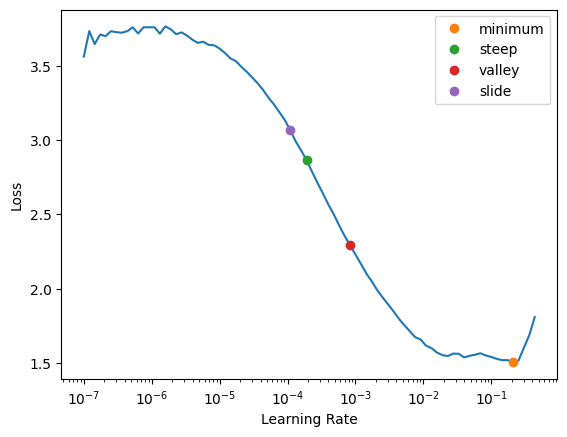

In [17]:

# path to your training data
path = Path('train')

# get image files in the training path
files = get_image_files(path)


# label function based on filename
def label_func(f):
    filename = f.name if isinstance(f, Path) else f
    return filename.split('_')[1]


# create the dataloaders for training data
dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(224))

# Create a cnn_learner
learn = cnn_learner(dls, resnet34, metrics=accuracy)

# Unfreeze the model to allow all layers to be trained
learn.unfreeze()

# Find the optimal learning rate for training
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Print the optimal learning rate
print(f"Minimum/10: {lrs.minimum:.2e}, steepest point: {lrs.steep:.2e}")

# Train the entire model with the chosen learning rate
learn.fit_one_cycle(5, lr_max=slice(lrs.minimum / 10, lrs.steep))



Get the classification report to see the accuracy of the model.

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
interp.print_classification_report()


              precision    recall  f1-score   support

           0       0.99      1.00      0.99        78
           1       0.99      0.99      0.99        75
           2       0.97      0.99      0.98        67
           3       1.00      0.97      0.98        93
           4       0.99      0.97      0.98        75
           5       0.97      1.00      0.98        89
           6       1.00      0.99      0.99        83
           7       0.98      0.99      0.98        83
           8       1.00      1.00      1.00        73
           9       0.99      0.98      0.98        84

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800


Plot the confusion matrix to see the accuracy of the model.

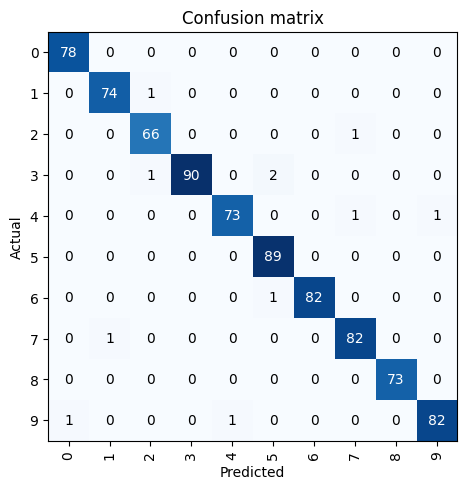

In [19]:
interp.plot_confusion_matrix()

count the losses and plot them 

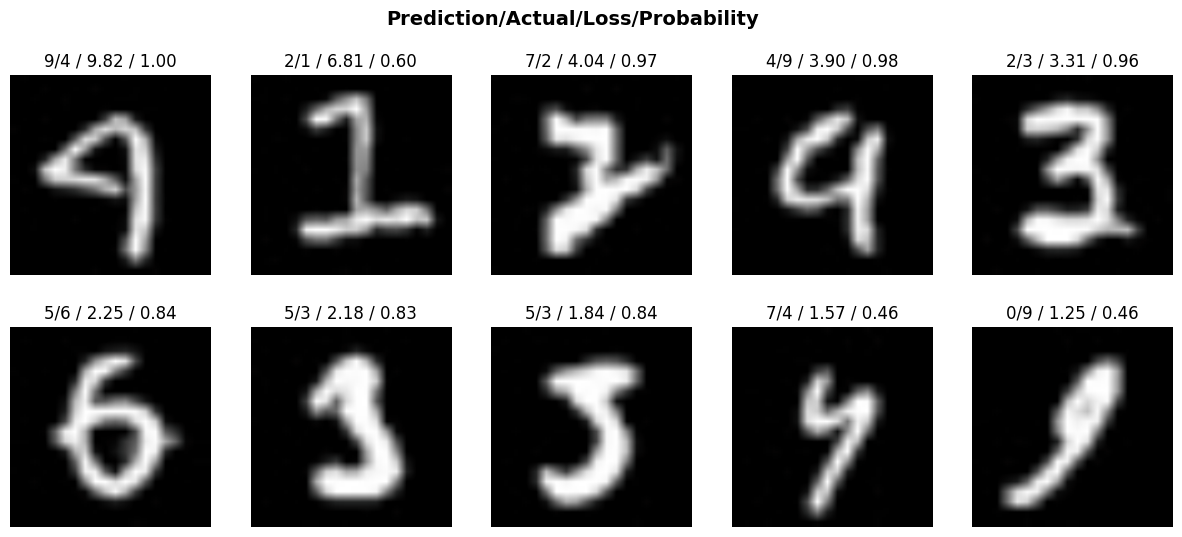

In [20]:
matrix = interp.confusion_matrix()
losses = np.sum(matrix) - np.trace(matrix) - 1
# Plot top losses
interp.plot_top_losses(losses, ncols=5)

#### 2.5.3 predict the test data 

In [21]:
files = get_image_files('test')
files_labels = [label_func(f) for f in files]
correct = 0
tested = 0
for i in range(len(files)):
    tested += 1
    # have to do this to avoid black lines that appear for some reason
    with learn.no_bar(), learn.no_logging():
        prediction = learn.predict(files[i])
    if prediction[0] == files_labels[i]:
        correct += 1
print(f'Accuracy is {correct * (100.0 / tested)}% ')


Accuracy is 98.10000000000001% 


### 2.5.4 train the model using alexnet
#### 2.5.5 load the data and train the model using alexnet

/home/kk/.local/lib/python3.10/site-packages/fastai/data/transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(col):
/home/kk/.local/lib/python3.10/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/home/kk/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kk/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_

Minimum/10: 3.31e-03, steepest point: 1.74e-03


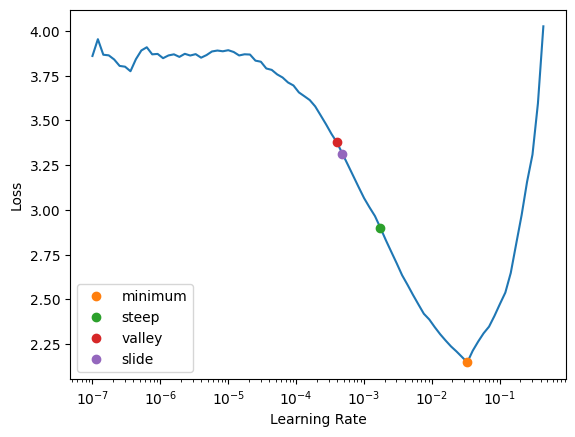

In [22]:
# path to your training data
path = Path('train')

# get image files in the training path
files = get_image_files(path)


# label function based on filename
def label_func(f):
    filename = f.name if isinstance(f, Path) else f
    return filename.split('_')[1]


# create the dataloaders for training data
dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(224))

# Create a cnn_learner
learn = cnn_learner(dls, alexnet, metrics=accuracy)

# Unfreeze the model to allow all layers to be trained
learn.unfreeze()

# Find the optimal learning rate for training
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Print the optimal learning rate
print(f"Minimum/10: {lrs.minimum:.2e}, steepest point: {lrs.steep:.2e}")

# Train the entire model with the chosen learning rate
learn.fit_one_cycle(5, lr_max=slice(lrs.minimum / 10, lrs.steep))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        76
           1       0.99      0.98      0.98        82
           2       0.99      0.96      0.98        85
           3       1.00      1.00      1.00        69
           4       0.99      0.97      0.98        76
           5       0.99      1.00      0.99        86
           6       0.97      0.99      0.98        77
           7       0.96      0.99      0.97        78
           8       1.00      1.00      1.00        83
           9       0.97      0.98      0.97        88

    accuracy                           0.98       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.98      0.99       800


Accuracy is 98.2% 


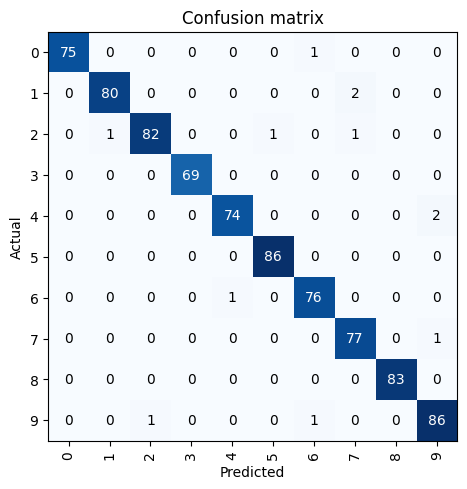

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.print_classification_report()
interp.plot_confusion_matrix()
files = get_image_files('test')
files_labels = [label_func(f) for f in files]
correct = 0
tested = 0
for i in range(len(files)):
    tested += 1
    # have to do this to avoid black lines that appear for some reason
    with learn.no_bar(), learn.no_logging():
        prediction = learn.predict(files[i])
    if prediction[0] == files_labels[i]:
        correct += 1
print(f'Accuracy is {correct * (100.0 / tested)}% ')

### 2.5.6 train the model using LeNet 
#### 2.5.7 load the data and train the model using LeNet

/home/kk/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/kk/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:49<00:00, 11.3MB/s]  


Minimum/10: 7.59e-04, steepest point: 3.98e-04


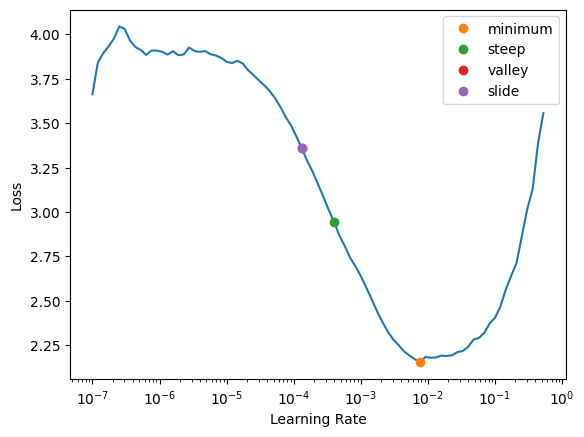

In [29]:
# path to your training data
path = Path('train')

# get image files in the training path
files = get_image_files(path)


# label function based on filename
def label_func(f):
    filename = f.name if isinstance(f, Path) else f
    return filename.split('_')[1]


# create the dataloaders for training data
dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(224))

# Create a cnn_learner
learn = cnn_learner(dls, vgg16, metrics=accuracy)

# Unfreeze the model to allow all layers to be trained
learn.unfreeze()

# Find the optimal learning rate for training
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Print the optimal learning rate
print(f"Minimum/10: {lrs.minimum:.2e}, steepest point: {lrs.steep:.2e}")

# Train the entire model with the chosen learning rate
learn.fit_one_cycle(5, lr_max=slice(lrs.minimum / 10, lrs.steep))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98        87
           1       0.97      1.00      0.98        63
           2       1.00      0.99      0.99        75
           3       0.99      1.00      0.99        84
           4       1.00      1.00      1.00        85
           5       0.96      0.98      0.97        88
           6       1.00      0.99      0.99        81
           7       0.97      0.96      0.97        80
           8       0.97      0.99      0.98        75
           9       0.96      0.94      0.95        82

    accuracy                           0.98       800
   macro avg       0.98      0.98      0.98       800
weighted avg       0.98      0.98      0.98       800


Accuracy is 98.10000000000001% 


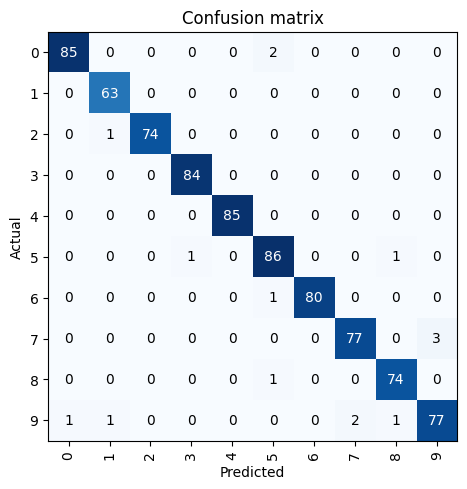

In [30]:
interp = ClassificationInterpretation.from_learner(learn)
interp.print_classification_report()
interp.plot_confusion_matrix()
files = get_image_files('test')
files_labels = [label_func(f) for f in files]
correct = 0
tested = 0
for i in range(len(files)):
    tested += 1
    # have to do this to avoid black lines that appear for some reason
    with learn.no_bar(), learn.no_logging():
        prediction = learn.predict(files[i])
    if prediction[0] == files_labels[i]:
        correct += 1
print(f'Accuracy is {correct * (100.0 / tested)}% ')